In [26]:
import xml.dom.minidom as minidom
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from matplotlib.patches import FancyBboxPatch
import numpy as np
import pandas as pd

plt.style.use('helv_math')
# import networkx as nx
# import pygraphviz as pgv
# from networkx.drawing.nx_agraph import graphviz_layout

In [79]:
def get_node_attr_from_cytoscape(xgmml_filename):
    doc = minidom.parse(xgmml_filename)

    nodes = {}
    for node in doc.getElementsByTagName("node"):
        for att in node.getElementsByTagName("att"):
            if att.getAttribute("name") == "shared name":
                shared_name = att.getAttribute("value")
                graphic = node.getElementsByTagName("graphics")
                if graphic:
                    graphic = graphic[0]
                else:
                    continue
                att = {
                    "name": node.getAttribute("label"),
                    "id": int(node.getAttribute("id")),
                    "shared_name": shared_name,
                    "x": float(graphic.getAttribute("x")),
                    "y": -float(graphic.getAttribute("y")), # in cytoscape y are negative at the top and positive at the bottom, it's the opposite in matplotlib so we multiply by -1
                    "w": float(graphic.getAttribute("w")),
                    "h": float(graphic.getAttribute("h"))}
                nodes[node.getAttribute("id")] = att
    
    # transform coord to remove negative values
    min_x = min(v["x"] for v in nodes.values())
    min_y = min(v["y"] for v in nodes.values())
    
    for node in nodes:
        nodes[node]["x"] = nodes[node]["x"] + abs(min_x)
        nodes[node]["y"] = nodes[node]["y"] + abs(min_y)
    
    edges = {}
    for edge in doc.getElementsByTagName("edge"):
        source = edge.getAttribute("source")
        target = edge.getAttribute("target")
        
        if not all(e in nodes for e in [source, target]):
            continue
        att = {"source": int(source), "target": int(target)}
        edges[edge.getAttribute("id")] = att
        
    return nodes, edges

In [80]:
up_down_df = pd.read_csv("/users/mickaelm/mnt/mickaelm/MLf5onto/Results/25_pyRRF_500_new_onto/SPI1.new.tsv", sep="\t", index_col=0)

In [81]:
nodes, edges = get_node_attr_from_cytoscape("edges_name.tsv.xgmml")

columns = ["up", "down", "other"]

for node in nodes:
    if nodes[node]["name"] == "sac":
        nodes[node]["color"] = "orange"
        nodes[node]["type"] = "short_node"
    elif nodes[node]["name"] == "mc":
        nodes[node]["color"] = "green"
        nodes[node]["type"] = "short_node"
    else:
        nodes[node]["color"] = "black"
        nodes[node]["type"] = "chart_node"
        node_name = nodes[node]["shared_name"]
        
        if node_name in up_down_df.index:
            values = up_down_df.loc[node_name, columns].tolist()
        else:
            values = (0., 0., 1.)
        
        for tag, val in zip(columns, values):
            nodes[node][tag] = val

In [82]:
PAD = 6
def custom_node_left(node, t_display, ax, fig):
    renderer = fig.canvas.get_renderer()
    
    # display coord of text + bbox
    graph_w_display, graph_h_display = (t_display["h"], t_display["h"])
    graph_w_fig, graph_h_fig = fig.transFigure.inverted().transform((graph_w_display, graph_h_display))
    graph_x_display, graph_y_display = (t_display["p0x"]-graph_w_display, t_display["p0y"])
    graph_x1_display, graph_y1_display = (t_display["p1x"], t_display["p1y"])

    graph_x_fig, graph_y_fig = fig.transFigure.inverted().transform((graph_x_display, graph_y_display))

    ax1 = fig.add_axes([graph_x_fig, graph_y_fig, graph_w_fig, graph_h_fig])
    up, down, other = (node["up"], node["down"], node["other"])
    count_sum = up + down + other
    up = up/count_sum
    down = down/count_sum
    other = other/count_sum
  
    ax1.barh([1], [up], color="#fb9a99", edgecolor="whitesmoke")
    ax1.barh([1], [down], left=[up], color="#a6cee3", edgecolor="whitesmoke")
    ax1.barh([1], [other], left=[up+down], color="lightgray", edgecolor="whitesmoke")
    ax1.set_xlim(-0.05, 1.05)
    ax1.set_ylim(0.45, 1.55)
    ax1.set_yticks([])
    ax1.set_xticks([])
#     ax1.axis("off")

    # draw major patch combining text and graph
    major_x_data, major_y_data = ax.transData.inverted().transform((graph_x_display, graph_y_display))
    major_x1_data, major_y1_data = ax.transData.inverted().transform((graph_x1_display, graph_y1_display))
    major_w_data = major_x1_data - major_x_data
    major_h_data = major_y1_data - major_y_data
    
    rect = Rectangle((major_x_data-1,major_y_data-1),major_w_data+2, major_h_data+2, linewidth=1,edgecolor='none',facecolor='none')
    p = ax.add_patch(rect)

    return p

In [83]:
# pd.DataFrame.from_dict(nodes.values()).sort_values("y").to_csv("node_coord.tsv", sep="\t")

In [86]:
nodes = {n[1]["id"]: n[1] for n in pd.read_csv("node_coord.tsv", sep="\t", index_col=0).T.to_dict().items()}

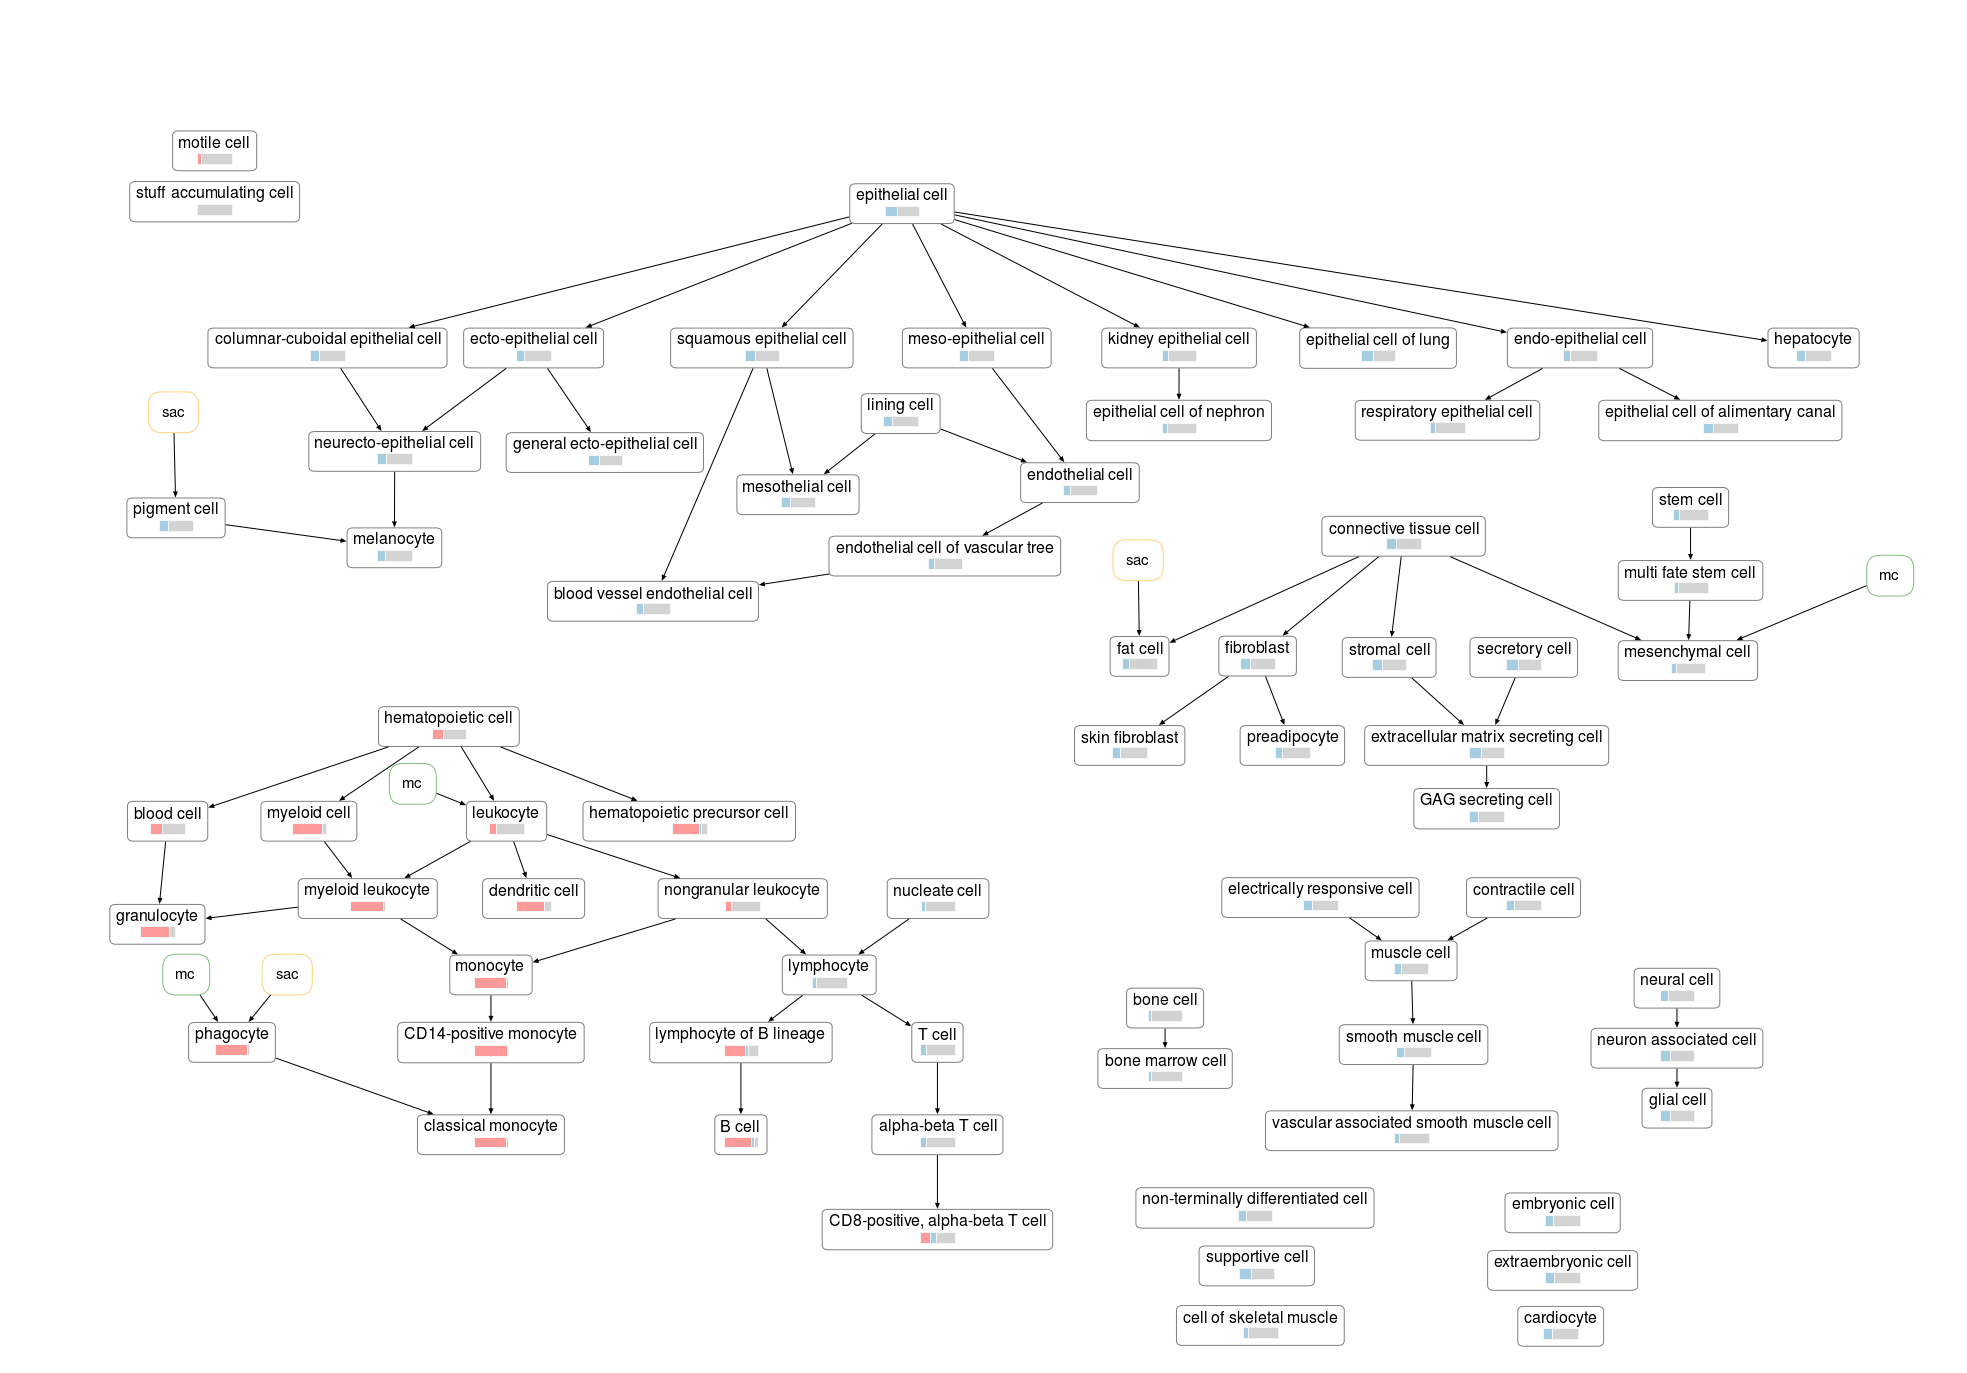

In [89]:
PAD = 0
def custom_node_bottom(node, t_display, chart_width_display, ax, fig):
    # display coord of text + bbox
    graph_w_display, graph_h_display = (chart_width_display, t_display["h"])
    graph_w_fig, graph_h_fig = fig.transFigure.inverted().transform((graph_w_display, graph_h_display))
    graph_x_display = t_display["p0x"] + (t_display["w"]-chart_width_display)/2
    graph_y_display = t_display["p0y"]-t_display["h"]
    graph_x1_display, graph_y1_display = (graph_x_display+chart_width_display, t_display["p0y"])

    graph_x_fig, graph_y_fig = fig.transFigure.inverted().transform((graph_x_display, graph_y_display))

    ax1 = fig.add_axes([graph_x_fig, graph_y_fig, graph_w_fig, graph_h_fig])
    up, down, other = (node["up"], node["down"], node["other"])
    count_sum = up + down + other
    up = up/count_sum
    down = down/count_sum
    other = other/count_sum
  
    ax1.barh([1], [up], color="#fb9a99", edgecolor="whitesmoke")
    ax1.barh([1], [down], left=[up], color="#a6cee3", edgecolor="whitesmoke")
    ax1.barh([1], [other], left=[up+down], color="lightgray", edgecolor="whitesmoke")
    ax1.set_xlim(-0.05, 1.05)
    ax1.set_ylim(0.45, 1.55)
    ax1.set_yticks([])
    ax1.set_xticks([])
    ax1.axis("off")

    # draw major patch combining text and graph
    major_x_data, major_y_data = ax.transData.inverted().transform((t_display["p0x"], t_display["p0y"] - t_display["h"]))
    major_x1_data, major_y1_data = ax.transData.inverted().transform((t_display["p1x"], t_display["p1y"]))
    major_w_data = major_x1_data - major_x_data
    major_h_data = major_y1_data - major_y_data
    
    rect = FancyBboxPatch((major_x_data-1,major_y_data-1),major_w_data+2, major_h_data+2, linewidth=1,edgecolor='grey',facecolor='none', boxstyle="round,pad=10")
    p = ax.add_patch(rect)

    return p

fig, ax = plt.subplots(figsize=(35,25))

ax.set_ylim(-100, 2800)
ax.set_xlim(-250, 3000)
node_to_text_display = {}
node_to_text = {}
node_to_patch = {}
node_to_patch_center = {}

for node_id, node in nodes.items():
    if node["type"] == "chart_node":
#         bbox = dict(facecolor='lightgrey', edgecolor=node["color"], alpha=0.5, pad=0)
        t = ax.text(node["x"], node["y"], node["name"], ha="center", va="center", fontsize=16)#, bbox=bbox)

        renderer = fig.canvas.get_renderer()

        # get display coord of the text (bbox not included)
        # so we manually add PAD
        bbox_text = t.get_window_extent(renderer=renderer)
        t_display = {
            "w": bbox_text.width + PAD*2,
            "h": bbox_text.height + PAD*2,
            "p0x": bbox_text.p0[0]-PAD,
            "p0y": bbox_text.p0[1]-PAD,
            "p1x": bbox_text.p1[0]+PAD,
            "p1y": bbox_text.p1[1]+PAD,}

        node_to_text_display[node_id] = t_display
        node_to_text[node_id] = t

wideleast_node = min([node_to_text_display[node["id"]] for node in nodes.values() if node["type"] == "chart_node"],
                    key=lambda x: x["w"])
wideleast_display = wideleast_node["w"]

for node_id, node in nodes.items():
    if node["type"] == "chart_node":
        p = custom_node_bottom(node, node_to_text_display[node_id], wideleast_display, ax, fig)
#         p = custom_node_left(node, node_to_text_display[node_id], ax, fig)
        node_to_patch[node_id] = p
    
        node_to_patch_center[node_id] = {
            "x": p.get_x() + p.get_width()/2,
            "y": p.get_y() + p.get_height()/2}
    else:
        node_to_patch_center[node_id] = {"x": node["x"], "y": node["y"]}
        bbox = dict(facecolor='none', edgecolor=node["color"], alpha=0.5, boxstyle="round,pad=.9")
        t = ax.text(node["x"], node["y"], node["name"], ha="center", va="center", fontsize=15, bbox=bbox)
        node_to_patch[node_id] = t
        

for edge_id, edge in edges.items():
    v, u = (edge["source"], edge["target"])
    pos_u, pos_v = (node_to_patch_center[u], node_to_patch_center[v])
    arrow_coord = (pos_u["x"], pos_u["y"], pos_v["x"], pos_v["y"])
    ux,uy, vx, vy = arrow_coord
    ax.annotate("", (vx,vy), xytext=(ux,uy), arrowprops=dict(
        facecolor='black', patchA=node_to_patch[u], patchB=node_to_patch[v], shrinkA=.1, shrinkB=20,lw=.01,ec="black",headwidth=5,headlength=6,width=1))
ax.axis("off")
fig.savefig("cl_spi1.pdf", bbox_inches='tight')
fig.savefig("cl_spi1.png", bbox_inches='tight')